# Sistema de Recomendação de Cartões de Crédito

Este notebook tem como objetivo:

1. Desenvolver um modelo preditivo para classificação do principal cartão para clientes
2. Aplicar o modelo de clientes na base prospects
3. Gerar arquivo final com cartão ideal (recomendação) para prospects

### Importar bibliotecas necessárias

In [1]:
# EDA e Visualização de Dados
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, f_oneway
from colorama import Fore, Back, Style

# Configurar formato de exibição para não usar notação científica
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True, precision=5)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, log_loss
from catboost import CatBoostClassifier, Pool, cv

# Otimização
import optuna

# Utilitários
import joblib

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Abrir Base Clientes

In [2]:
df_clientes = pd.read_csv('./datasets/clientes.csv')

In [3]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Cliente                   1000 non-null   object 
 1   Nome                         1000 non-null   object 
 2   Idade                        1000 non-null   int64  
 3   Viagens                      1000 non-null   int64  
 4   Restaurantes                 1000 non-null   int64  
 5   Entretenimento               1000 non-null   int64  
 6   Cashback                     1000 non-null   int64  
 7   Compras online               1000 non-null   int64  
 8   Farmácias                    1000 non-null   int64  
 9   Programas de Milhagem        1000 non-null   int64  
 10  Postos de Combustível        1000 non-null   int64  
 11  Mercados                     1000 non-null   int64  
 12  Cidade                       1000 non-null   object 
 13  Cargo              

In [4]:
# Remover colunas únicas
df_clientes.drop(columns=['ID_Cliente', 'Nome'], axis=1, inplace=True)

In [5]:
num_vars = df_clientes.select_dtypes(include=['number']).columns
cat_vars = df_clientes.select_dtypes(exclude=['object']).columns
target = 'Principal Cartão'

### Testes de Hipóteses

In [6]:
# Testes de hipóteses entre Target Categórica e Numéricas (ANOVA)
for num_col in num_vars:
  groups = [df_clientes[df_clientes[target] == val][num_col] for val in df_clientes[target].unique()]
  stat, p = f_oneway(*groups)
  print(f"{Fore.RED if p < 0.05 else Fore.WHITE}"
        f"ANOVA entre {num_col} e {target}: p-valor = {p}")

ANOVA entre Idade e Principal Cartão: p-valor = 0.02334622684107804
ANOVA entre Viagens e Principal Cartão: p-valor = 4.59308651849609e-78
ANOVA entre Restaurantes e Principal Cartão: p-valor = 6.679790462858737e-13
ANOVA entre Entretenimento e Principal Cartão: p-valor = 5.089212006248722e-18
ANOVA entre Cashback e Principal Cartão: p-valor = 8.77437441029354e-12
ANOVA entre Compras online e Principal Cartão: p-valor = 0.00717148660617559
ANOVA entre Farmácias e Principal Cartão: p-valor = 0.0006390735697304401
ANOVA entre Programas de Milhagem e Principal Cartão: p-valor = 0.001269305962592174
ANOVA entre Postos de Combustível e Principal Cartão: p-valor = 0.11255638879254316
ANOVA entre Mercados e Principal Cartão: p-valor = 0.034152908342727085
ANOVA entre Tempo na Empresa e Principal Cartão: p-valor = 0.3209237036500026
ANOVA entre Pessoas em Casa e Principal Cartão: p-valor = 0.05946641455988785
ANOVA entre Renda e Principal Cartão: p-valor = 1.5360217142979344e-34
ANOVA entre In

In [7]:
# Analisando relação entre variáveis explicativas e targets
for col in num_vars:
  fig = px.box(df_clientes, x=target, y=col, title=f"{col} por {target}")
  fig.show()

for col in cat_vars:
  fig = px.histogram(df_clientes, x=col, color=target, title=f"{col} por {target}")
  fig.show()

### Modelo Catboost com Validação Cruzada

In [8]:
selected_features = ['Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online', 'Farmácias', 'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score']
X = df_clientes[selected_features]
y = df_clientes[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

params = {
  'iterations': 1000,
  'learning_rate': 0.05,
  'depth': 6,
  'l2_leaf_reg': 3,
  'random_strength': 2,
  'loss_function': 'MultiClass',
  'eval_metric': 'MultiClass',
}

model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

model.fit(X_train, y_train)
# Obter o log loss médio
best_score = model.best_score_['learn']['MultiClass']
print(f"LogLoss no treinamento: {best_score}")

0:	learn: 3.1361616	total: 53.8ms	remaining: 53.8s
1:	learn: 3.0966905	total: 59.7ms	remaining: 29.8s
2:	learn: 3.0415708	total: 65.4ms	remaining: 21.7s
3:	learn: 2.9918112	total: 70.6ms	remaining: 17.6s
4:	learn: 2.9479092	total: 75.7ms	remaining: 15.1s
5:	learn: 2.9060745	total: 81.4ms	remaining: 13.5s
6:	learn: 2.8958633	total: 82.4ms	remaining: 11.7s
7:	learn: 2.8461542	total: 87.3ms	remaining: 10.8s
8:	learn: 2.8098443	total: 92.6ms	remaining: 10.2s
9:	learn: 2.7748998	total: 96.9ms	remaining: 9.59s
10:	learn: 2.7366319	total: 101ms	remaining: 9.07s
11:	learn: 2.7120453	total: 106ms	remaining: 8.71s
12:	learn: 2.6740911	total: 110ms	remaining: 8.35s
13:	learn: 2.6420074	total: 112ms	remaining: 7.88s
14:	learn: 2.6062796	total: 116ms	remaining: 7.59s
15:	learn: 2.5769803	total: 121ms	remaining: 7.45s
16:	learn: 2.5486886	total: 125ms	remaining: 7.22s
17:	learn: 2.5133635	total: 129ms	remaining: 7.01s
18:	learn: 2.4873181	total: 133ms	remaining: 6.84s
19:	learn: 2.4615481	total: 137

In [9]:
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)
print(f"LogLoss no conjunto de teste: {test_loss:.2f}")

LogLoss no conjunto de teste: 1.46


### Otimizar com Optuna

In [10]:
# Definir a função objetivo para otimização
def objective(trial):
  # Definir o espaço de busca para os hiperparâmetros
  params = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'depth': trial.suggest_int('depth', 4, 10),
    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1, 10),
    'random_strength': trial.suggest_uniform('random_strength', 0, 10),
    'loss_function': 'MultiClass',
    'eval_metric': 'MultiClass',
  }

  model = CatBoostClassifier(**params, random_seed=42, auto_class_weights='Balanced')

  model.fit(X_train, y_train)
  best_score = model.best_score_['learn']['MultiClass']

  return best_score

# Criar um estudo e otimizar
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Ajuste o número de trials conforme necessário

# Obter os melhores parâmetros
best_params = study.best_params
best_metric = study.best_value
print("Melhores parâmetros:", best_params)
print("Melhor métrica:", best_metric)

[I 2025-04-08 14:51:34,358] A new study created in memory with name: no-name-c36142e0-effc-4361-9606-0039be52360c


0:	learn: 3.1648460	total: 4.19ms	remaining: 2.01s
1:	learn: 3.1512503	total: 9.98ms	remaining: 2.38s
2:	learn: 3.1328783	total: 16.4ms	remaining: 2.61s
3:	learn: 3.1165394	total: 23.1ms	remaining: 2.74s
4:	learn: 3.1019234	total: 28.6ms	remaining: 2.72s
5:	learn: 3.0875894	total: 34.7ms	remaining: 2.75s
6:	learn: 3.0836717	total: 36.3ms	remaining: 2.45s
7:	learn: 3.0682152	total: 39.2ms	remaining: 2.31s
8:	learn: 3.0543369	total: 44.8ms	remaining: 2.34s
9:	learn: 3.0416993	total: 52.8ms	remaining: 2.48s
10:	learn: 3.0260957	total: 60.9ms	remaining: 2.6s
11:	learn: 3.0217073	total: 62.8ms	remaining: 2.45s
12:	learn: 3.0120914	total: 67.2ms	remaining: 2.41s
13:	learn: 2.9966173	total: 74.3ms	remaining: 2.47s
14:	learn: 2.9834804	total: 78ms	remaining: 2.42s
15:	learn: 2.9694478	total: 82.9ms	remaining: 2.4s
16:	learn: 2.9568552	total: 87.4ms	remaining: 2.38s
17:	learn: 2.9453438	total: 91ms	remaining: 2.34s
18:	learn: 2.9305738	total: 94.8ms	remaining: 2.3s
19:	learn: 2.9187285	total: 9

/tmp/ipykernel_49947/3712176459.py:7: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_49947/3712176459.py:8: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/tmp/ipykernel_49947/3712176459.py:9: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.



42:	learn: 2.6549340	total: 181ms	remaining: 1.84s
43:	learn: 2.6448513	total: 185ms	remaining: 1.83s
44:	learn: 2.6377124	total: 187ms	remaining: 1.81s
45:	learn: 2.6264469	total: 191ms	remaining: 1.8s
46:	learn: 2.6172890	total: 195ms	remaining: 1.8s
47:	learn: 2.6069762	total: 199ms	remaining: 1.79s
48:	learn: 2.5993529	total: 203ms	remaining: 1.78s
49:	learn: 2.5902341	total: 207ms	remaining: 1.78s
50:	learn: 2.5817630	total: 210ms	remaining: 1.77s
51:	learn: 2.5730804	total: 214ms	remaining: 1.76s
52:	learn: 2.5641775	total: 218ms	remaining: 1.75s
53:	learn: 2.5541494	total: 221ms	remaining: 1.75s
54:	learn: 2.5454560	total: 223ms	remaining: 1.73s
55:	learn: 2.5355128	total: 227ms	remaining: 1.72s
56:	learn: 2.5275089	total: 230ms	remaining: 1.71s
57:	learn: 2.5168700	total: 233ms	remaining: 1.7s
58:	learn: 2.5084477	total: 237ms	remaining: 1.69s
59:	learn: 2.5019741	total: 238ms	remaining: 1.67s
60:	learn: 2.4887964	total: 242ms	remaining: 1.67s
61:	learn: 2.4803674	total: 246ms	

[I 2025-04-08 14:51:36,182] Trial 0 finished with value: 0.6799247346759966 and parameters: {'iterations': 480, 'depth': 6, 'learning_rate': 0.028231392207339466, 'l2_leaf_reg': 6.617785875901867, 'random_strength': 6.330099064070138}. Best is trial 0 with value: 0.6799247346759966.


0:	learn: 3.0567310	total: 74.4ms	remaining: 34.6s
1:	learn: 2.9377535	total: 142ms	remaining: 33s
2:	learn: 2.8599301	total: 147ms	remaining: 22.7s
3:	learn: 2.7887198	total: 156ms	remaining: 18.1s
4:	learn: 2.7314441	total: 159ms	remaining: 14.7s
5:	learn: 2.6444356	total: 225ms	remaining: 17.3s
6:	learn: 2.5736229	total: 264ms	remaining: 17.3s
7:	learn: 2.5226504	total: 267ms	remaining: 15.3s
8:	learn: 2.4499675	total: 332ms	remaining: 16.8s
9:	learn: 2.3726172	total: 345ms	remaining: 15.7s
10:	learn: 2.3074978	total: 417ms	remaining: 17.3s
11:	learn: 2.2652854	total: 425ms	remaining: 16.1s
12:	learn: 2.2358579	total: 427ms	remaining: 14.9s
13:	learn: 2.1855619	total: 512ms	remaining: 16.5s
14:	learn: 2.1377580	total: 531ms	remaining: 16s
15:	learn: 2.0817745	total: 569ms	remaining: 16s
16:	learn: 2.0234541	total: 603ms	remaining: 15.9s
17:	learn: 1.9746592	total: 679ms	remaining: 16.9s
18:	learn: 1.9300125	total: 749ms	remaining: 17.6s
19:	learn: 1.8860726	total: 812ms	remaining: 1

[I 2025-04-08 14:52:05,624] Trial 1 finished with value: 0.06089739592507706 and parameters: {'iterations': 466, 'depth': 10, 'learning_rate': 0.05976446731674393, 'l2_leaf_reg': 1.2477483432489704, 'random_strength': 3.2522506273851604}. Best is trial 1 with value: 0.06089739592507706.


0:	learn: 3.0899914	total: 15ms	remaining: 4.85s
1:	learn: 3.0063814	total: 29.8ms	remaining: 4.82s
2:	learn: 2.9247436	total: 43.2ms	remaining: 4.64s
3:	learn: 2.8420485	total: 56.7ms	remaining: 4.55s
4:	learn: 2.7836334	total: 61.1ms	remaining: 3.91s
5:	learn: 2.7233029	total: 75.3ms	remaining: 4s
6:	learn: 2.6611360	total: 89.3ms	remaining: 4.05s
7:	learn: 2.6071530	total: 104ms	remaining: 4.12s
8:	learn: 2.5507285	total: 117ms	remaining: 4.11s
9:	learn: 2.4919029	total: 132ms	remaining: 4.14s
10:	learn: 2.4437808	total: 145ms	remaining: 4.15s
11:	learn: 2.4020796	total: 158ms	remaining: 4.13s
12:	learn: 2.3575938	total: 172ms	remaining: 4.12s
13:	learn: 2.3147514	total: 185ms	remaining: 4.11s
14:	learn: 2.2742892	total: 199ms	remaining: 4.11s
15:	learn: 2.2293365	total: 213ms	remaining: 4.12s
16:	learn: 2.1927387	total: 229ms	remaining: 4.15s
17:	learn: 2.1527235	total: 244ms	remaining: 4.16s
18:	learn: 2.1145162	total: 259ms	remaining: 4.17s
19:	learn: 2.0845105	total: 273ms	remai

[I 2025-04-08 14:52:09,957] Trial 2 finished with value: 0.1576676701367104 and parameters: {'iterations': 325, 'depth': 8, 'learning_rate': 0.059276380944625666, 'l2_leaf_reg': 1.8848589600673848, 'random_strength': 3.2911383146506457}. Best is trial 1 with value: 0.06089739592507706.


315:	learn: 0.1636850	total: 4.13s	remaining: 118ms
316:	learn: 0.1629309	total: 4.15s	remaining: 105ms
317:	learn: 0.1622887	total: 4.16s	remaining: 91.6ms
318:	learn: 0.1617066	total: 4.17s	remaining: 78.5ms
319:	learn: 0.1610868	total: 4.19s	remaining: 65.4ms
320:	learn: 0.1603775	total: 4.2s	remaining: 52.4ms
321:	learn: 0.1597350	total: 4.21s	remaining: 39.3ms
322:	learn: 0.1590869	total: 4.23s	remaining: 26.2ms
323:	learn: 0.1583519	total: 4.24s	remaining: 13.1ms
324:	learn: 0.1576677	total: 4.25s	remaining: 0us
0:	learn: 3.1628516	total: 2.48ms	remaining: 2.41s
1:	learn: 3.1414283	total: 4.78ms	remaining: 2.32s
2:	learn: 3.1276484	total: 6.77ms	remaining: 2.19s
3:	learn: 3.1047343	total: 8.87ms	remaining: 2.15s
4:	learn: 3.0790733	total: 11.7ms	remaining: 2.27s
5:	learn: 3.0648404	total: 13.9ms	remaining: 2.24s
6:	learn: 3.0427629	total: 16.3ms	remaining: 2.25s
7:	learn: 3.0203386	total: 18.6ms	remaining: 2.24s
8:	learn: 3.0031498	total: 20.7ms	remaining: 2.21s
9:	learn: 2.98454

[I 2025-04-08 14:52:12,047] Trial 3 finished with value: 0.27523381254251567 and parameters: {'iterations': 973, 'depth': 5, 'learning_rate': 0.012720932587673418, 'l2_leaf_reg': 1.0253073795885128, 'random_strength': 4.855127730941849}. Best is trial 1 with value: 0.06089739592507706.


972:	learn: 0.2752338	total: 2.02s	remaining: 0us
0:	learn: 3.1616288	total: 2.38ms	remaining: 907ms
1:	learn: 3.1453505	total: 4.79ms	remaining: 911ms
2:	learn: 3.1254851	total: 6.97ms	remaining: 880ms
3:	learn: 3.1086721	total: 9.64ms	remaining: 911ms
4:	learn: 3.0889900	total: 12.1ms	remaining: 910ms
5:	learn: 3.0764449	total: 14ms	remaining: 878ms
6:	learn: 3.0561910	total: 16.1ms	remaining: 863ms
7:	learn: 3.0359852	total: 18.5ms	remaining: 864ms
8:	learn: 3.0190887	total: 20.5ms	remaining: 850ms
9:	learn: 3.0030229	total: 22.5ms	remaining: 838ms
10:	learn: 2.9905333	total: 24.6ms	remaining: 830ms
11:	learn: 2.9759170	total: 26.7ms	remaining: 822ms
12:	learn: 2.9578759	total: 28.7ms	remaining: 816ms
13:	learn: 2.9378765	total: 31.3ms	remaining: 823ms
14:	learn: 2.9221912	total: 33.4ms	remaining: 817ms
15:	learn: 2.9052229	total: 35.4ms	remaining: 811ms
16:	learn: 2.8900631	total: 37.9ms	remaining: 814ms
17:	learn: 2.8748190	total: 40ms	remaining: 809ms
18:	learn: 2.8601234	total: 

[I 2025-04-08 14:52:12,927] Trial 4 finished with value: 0.8240307530685346 and parameters: {'iterations': 382, 'depth': 5, 'learning_rate': 0.012186988341268648, 'l2_leaf_reg': 1.6855930003451967, 'random_strength': 0.34633352531899364}. Best is trial 1 with value: 0.06089739592507706.


347:	learn: 0.8894495	total: 769ms	remaining: 75.1ms
348:	learn: 0.8872281	total: 772ms	remaining: 73ms
349:	learn: 0.8852327	total: 774ms	remaining: 70.8ms
350:	learn: 0.8834813	total: 776ms	remaining: 68.5ms
351:	learn: 0.8810767	total: 779ms	remaining: 66.4ms
352:	learn: 0.8791410	total: 781ms	remaining: 64.1ms
353:	learn: 0.8770562	total: 783ms	remaining: 61.9ms
354:	learn: 0.8749186	total: 785ms	remaining: 59.7ms
355:	learn: 0.8731685	total: 787ms	remaining: 57.5ms
356:	learn: 0.8710903	total: 790ms	remaining: 55.3ms
357:	learn: 0.8691288	total: 792ms	remaining: 53.1ms
358:	learn: 0.8671810	total: 794ms	remaining: 50.9ms
359:	learn: 0.8652965	total: 796ms	remaining: 48.6ms
360:	learn: 0.8631690	total: 798ms	remaining: 46.4ms
361:	learn: 0.8613493	total: 800ms	remaining: 44.2ms
362:	learn: 0.8590763	total: 802ms	remaining: 42ms
363:	learn: 0.8572505	total: 805ms	remaining: 39.8ms
364:	learn: 0.8554092	total: 807ms	remaining: 37.6ms
365:	learn: 0.8535555	total: 809ms	remaining: 35.4

[I 2025-04-08 14:52:13,810] Trial 5 finished with value: 0.4946609040099383 and parameters: {'iterations': 389, 'depth': 5, 'learning_rate': 0.05201452110558888, 'l2_leaf_reg': 6.829707706212247, 'random_strength': 1.0401400354358092}. Best is trial 1 with value: 0.06089739592507706.


316:	learn: 0.5816066	total: 697ms	remaining: 158ms
317:	learn: 0.5791918	total: 699ms	remaining: 156ms
318:	learn: 0.5779249	total: 701ms	remaining: 154ms
319:	learn: 0.5761215	total: 704ms	remaining: 152ms
320:	learn: 0.5746652	total: 706ms	remaining: 150ms
321:	learn: 0.5734243	total: 708ms	remaining: 147ms
322:	learn: 0.5716045	total: 710ms	remaining: 145ms
323:	learn: 0.5702229	total: 712ms	remaining: 143ms
324:	learn: 0.5688986	total: 714ms	remaining: 141ms
325:	learn: 0.5675412	total: 716ms	remaining: 138ms
326:	learn: 0.5661315	total: 718ms	remaining: 136ms
327:	learn: 0.5648926	total: 720ms	remaining: 134ms
328:	learn: 0.5636611	total: 722ms	remaining: 132ms
329:	learn: 0.5624280	total: 724ms	remaining: 130ms
330:	learn: 0.5607804	total: 726ms	remaining: 127ms
331:	learn: 0.5593064	total: 728ms	remaining: 125ms
332:	learn: 0.5576224	total: 731ms	remaining: 123ms
333:	learn: 0.5562488	total: 733ms	remaining: 121ms
334:	learn: 0.5550406	total: 735ms	remaining: 118ms
335:	learn: 

[I 2025-04-08 14:52:25,684] Trial 6 finished with value: 0.12704039907946696 and parameters: {'iterations': 854, 'depth': 8, 'learning_rate': 0.04215659390757147, 'l2_leaf_reg': 3.303567690834493, 'random_strength': 2.371374579143204}. Best is trial 1 with value: 0.06089739592507706.


846:	learn: 0.1282943	total: 11.6s	remaining: 95.8ms
847:	learn: 0.1280872	total: 11.6s	remaining: 82.1ms
848:	learn: 0.1279099	total: 11.6s	remaining: 68.4ms
849:	learn: 0.1277479	total: 11.6s	remaining: 54.7ms
850:	learn: 0.1275856	total: 11.6s	remaining: 41ms
851:	learn: 0.1274088	total: 11.7s	remaining: 27.4ms
852:	learn: 0.1272142	total: 11.7s	remaining: 13.7ms
853:	learn: 0.1270404	total: 11.7s	remaining: 0us
0:	learn: 3.1531733	total: 64.2ms	remaining: 29.8s
1:	learn: 3.1269856	total: 130ms	remaining: 30.1s
2:	learn: 3.1054516	total: 134ms	remaining: 20.7s
3:	learn: 3.0842100	total: 140ms	remaining: 16.2s
4:	learn: 3.0665880	total: 143ms	remaining: 13.2s
5:	learn: 3.0442116	total: 169ms	remaining: 13s
6:	learn: 3.0226478	total: 176ms	remaining: 11.5s
7:	learn: 3.0014265	total: 202ms	remaining: 11.6s
8:	learn: 2.9790198	total: 268ms	remaining: 13.6s
9:	learn: 2.9535477	total: 276ms	remaining: 12.6s
10:	learn: 2.9309749	total: 344ms	remaining: 14.2s
11:	learn: 2.9135666	total: 351

[I 2025-04-08 14:52:47,446] Trial 7 finished with value: 0.5671568429754997 and parameters: {'iterations': 466, 'depth': 10, 'learning_rate': 0.025549862294471582, 'l2_leaf_reg': 3.3395536930323573, 'random_strength': 8.707115031707968}. Best is trial 1 with value: 0.06089739592507706.


0:	learn: 3.1690026	total: 2.62ms	remaining: 469ms
1:	learn: 3.1563669	total: 4.98ms	remaining: 444ms
2:	learn: 3.1463989	total: 7.02ms	remaining: 414ms
3:	learn: 3.1343552	total: 9.25ms	remaining: 407ms
4:	learn: 3.1211894	total: 12.2ms	remaining: 425ms
5:	learn: 3.1119258	total: 14.3ms	remaining: 414ms
6:	learn: 3.0988452	total: 16.3ms	remaining: 403ms
7:	learn: 3.0863574	total: 18.5ms	remaining: 398ms
8:	learn: 3.0756667	total: 20.6ms	remaining: 391ms
9:	learn: 3.0651603	total: 23.1ms	remaining: 392ms
10:	learn: 3.0553289	total: 25.6ms	remaining: 394ms
11:	learn: 3.0456914	total: 27.8ms	remaining: 390ms
12:	learn: 3.0313887	total: 29.8ms	remaining: 382ms
13:	learn: 3.0218089	total: 31.8ms	remaining: 377ms
14:	learn: 3.0102704	total: 33.8ms	remaining: 372ms
15:	learn: 2.9997090	total: 35.8ms	remaining: 367ms
16:	learn: 2.9892386	total: 38ms	remaining: 364ms
17:	learn: 2.9788542	total: 40ms	remaining: 360ms
18:	learn: 2.9696631	total: 42.1ms	remaining: 357ms
19:	learn: 2.9585223	total

[I 2025-04-08 14:52:47,891] Trial 8 finished with value: 1.9350218346818875 and parameters: {'iterations': 180, 'depth': 5, 'learning_rate': 0.02498761314899481, 'l2_leaf_reg': 7.494034177307049, 'random_strength': 4.500020791859882}. Best is trial 1 with value: 0.06089739592507706.


168:	learn: 1.9831953	total: 393ms	remaining: 25.6ms
169:	learn: 1.9805930	total: 395ms	remaining: 23.2ms
170:	learn: 1.9760320	total: 398ms	remaining: 20.9ms
171:	learn: 1.9708268	total: 400ms	remaining: 18.6ms
172:	learn: 1.9679915	total: 403ms	remaining: 16.3ms
173:	learn: 1.9606782	total: 405ms	remaining: 14ms
174:	learn: 1.9550707	total: 408ms	remaining: 11.7ms
175:	learn: 1.9512822	total: 410ms	remaining: 9.33ms
176:	learn: 1.9476740	total: 413ms	remaining: 6.99ms
177:	learn: 1.9430910	total: 415ms	remaining: 4.66ms
178:	learn: 1.9382664	total: 417ms	remaining: 2.33ms
179:	learn: 1.9350218	total: 419ms	remaining: 0us
0:	learn: 3.1419966	total: 1.53ms	remaining: 873ms
1:	learn: 3.0918047	total: 2.95ms	remaining: 842ms
2:	learn: 3.0794475	total: 3.68ms	remaining: 697ms
3:	learn: 3.0266135	total: 5.07ms	remaining: 720ms
4:	learn: 2.9766256	total: 6.62ms	remaining: 750ms
5:	learn: 2.9226029	total: 8.07ms	remaining: 761ms
6:	learn: 2.8914654	total: 9.81ms	remaining: 792ms
7:	learn: 2.

[I 2025-04-08 14:52:48,717] Trial 9 finished with value: 0.24951653049737488 and parameters: {'iterations': 572, 'depth': 4, 'learning_rate': 0.07235635256162096, 'l2_leaf_reg': 4.204148066685629, 'random_strength': 6.711875465471753}. Best is trial 1 with value: 0.06089739592507706.


541:	learn: 0.2606064	total: 743ms	remaining: 41.1ms
542:	learn: 0.2601982	total: 744ms	remaining: 39.8ms
543:	learn: 0.2597800	total: 746ms	remaining: 38.4ms
544:	learn: 0.2596556	total: 747ms	remaining: 37ms
545:	learn: 0.2593494	total: 748ms	remaining: 35.6ms
546:	learn: 0.2588681	total: 750ms	remaining: 34.3ms
547:	learn: 0.2585618	total: 751ms	remaining: 32.9ms
548:	learn: 0.2582905	total: 753ms	remaining: 31.5ms
549:	learn: 0.2577269	total: 754ms	remaining: 30.2ms
550:	learn: 0.2574112	total: 756ms	remaining: 28.8ms
551:	learn: 0.2570269	total: 757ms	remaining: 27.4ms
552:	learn: 0.2567383	total: 759ms	remaining: 26.1ms
553:	learn: 0.2564452	total: 760ms	remaining: 24.7ms
554:	learn: 0.2560144	total: 762ms	remaining: 23.3ms
555:	learn: 0.2556691	total: 763ms	remaining: 22ms
556:	learn: 0.2551287	total: 765ms	remaining: 20.6ms
557:	learn: 0.2548521	total: 766ms	remaining: 19.2ms
558:	learn: 0.2546759	total: 768ms	remaining: 17.9ms
559:	learn: 0.2543000	total: 769ms	remaining: 16.5

In [11]:
# Treinar o modelo final com os parâmetros otimizados
best_model = CatBoostClassifier(**best_params, verbose=False, random_seed=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
probs = best_model.predict_proba(X_test)
test_loss = log_loss(y_test, probs)
print(f"LogLoss no conjunto de testes: {test_loss:.2f}")

LogLoss no conjunto de testes: 1.74



Relatório de Classificação:
                                         precision    recall  f1-score   support

       Rocketseat Mastercard Life Basic       0.45      0.41      0.43        79
       Rocketseat Mastercard Life Elite       0.45      0.29      0.36        17
    Rocketseat Mastercard Life Platinum       0.00      0.00      0.00         1
      Rocketseat Mastercard Life Select       0.50      0.44      0.47        25
   Rocketseat Mastercard Shopping Basic       0.36      0.60      0.45        40
   Rocketseat Mastercard Shopping Elite       0.38      0.43      0.40         7
Rocketseat Mastercard Shopping Platinum       0.00      0.00      0.00         2
  Rocketseat Mastercard Shopping Select       0.30      0.43      0.35        14
     Rocketseat Mastercard Travel Basic       0.48      0.78      0.59        45
     Rocketseat Mastercard Travel Elite       0.50      0.11      0.18         9
  Rocketseat Mastercard Travel Platinum       0.00      0.00      0.00         

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/emerson/.local/share/virtualenvs/final_challenge-EoF2KZun/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



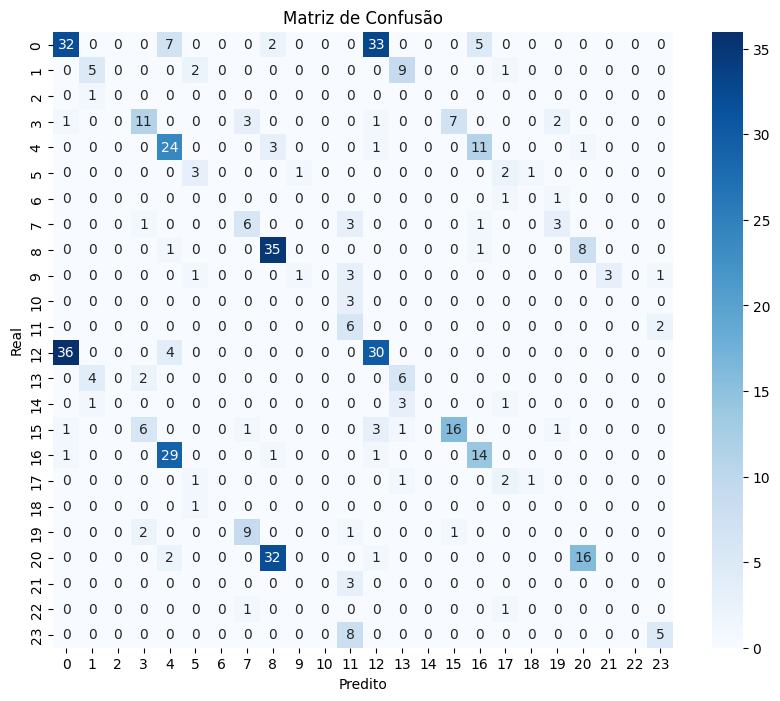

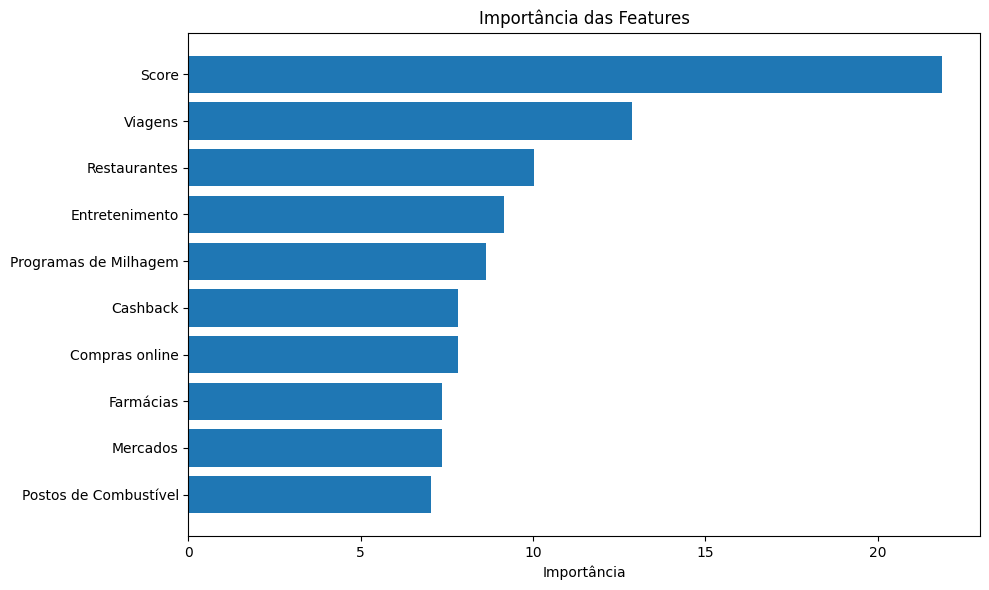

In [12]:
# Calcular e exibir métricas
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Criar matriz de confusão
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

# Plotar importância das features
plt.figure(figsize=(10, 6))
feature_importance = pd.DataFrame({
  'feature': selected_features,
  'importance': model.feature_importances_
}).sort_values('importance', ascending=True)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Importância das Features')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

### Salvar Modelo

In [13]:
joblib.dump(best_model, 'modelo_recomendacao.pkl')

['modelo_recomendacao.pkl']

### Abrir Base Prospects com Score

In [14]:
# Carregar Prospects
df_prospects = pd.read_csv('./datasets/prospects_com_score.csv')

In [15]:
df_prospects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID_Prospect                  500 non-null    object 
 1   Nome                         500 non-null    object 
 2   Idade                        500 non-null    int64  
 3   Viagens                      500 non-null    int64  
 4   Restaurantes                 500 non-null    int64  
 5   Entretenimento               500 non-null    int64  
 6   Cashback                     500 non-null    int64  
 7   Compras online               500 non-null    int64  
 8   Farmácias                    500 non-null    int64  
 9   Programas de Milhagem        500 non-null    int64  
 10  Postos de Combustível        500 non-null    int64  
 11  Mercados                     500 non-null    int64  
 12  Cidade                       500 non-null    object 
 13  Cargo               

### Carregar Modelo

In [16]:
modelo = joblib.load('./modelo_recomendacao.pkl')

### Preparar dados

In [17]:
# Preparar dados
selected_features = ['Viagens', 'Restaurantes', 'Entretenimento', 'Cashback', 'Compras online', 'Farmácias', 'Programas de Milhagem', 'Postos de Combustível', 'Mercados', 'Score']
X_prospects = df_prospects[selected_features]

### Realizar Predição

In [18]:
# Fazer previsões
df_prospects['Principal Cartão'] = modelo.predict(X_prospects).squeeze()

### Salvar Resultados da Recomendação

In [19]:
# Salvar resultados
df_prospects.to_csv('./datasets/prospects_com_recomendacao.csv', index=False)